# Randomness and prediction

## Importing libraries

In [1]:
# Data opening libraries
import pandas as pd
import numpy as np
import numpy.random as rnd
import warnings
warnings.filterwarnings('ignore')

# Plotting libraries
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn
from mplsoccer import Sbopen, Pitch

# Statistical model fitting libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Others
from scipy.stats import poisson,skellam
import time

## Simulating a match

### Setting parameters

In [2]:
# Defining match length
match_minutes = 90

# Defining the average goals per match
goals_per_match = 2.79

# Defining the probability of a goal per minute
prob_per_minute = np.array(goals_per_match/match_minutes)
print('The probability of a goal per minute is %5.5f. \n' % prob_per_minute )

The probability of a goal per minute is 0.03100. 



### Simulating a single game

In [3]:
# Counting the number of goals
goals=0

for minute in range(match_minutes):
    # Generating a random number between 0 and 1.
    r=rnd.rand(1,1)
    
    # Printing an X when there is a goal and a zero otherwise.
    if (r < prob_per_minute):
        # Goal - if the random number is less than the goal probability.
        print('X', end = ' ')
        goals=goals+1
        time.sleep(1)  # longer pause:
    else:
        print('o', end = ' ')
        time.sleep(0.1)  # short pause
print('\n')
print('Final whistle. \n \nThere were ' + str(goals) + ' goals.')

o o o o o o o o o o o o o o X o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o X o o o o o o o o o o o o o o o o o o o o o o o o o o o 

Final whistle. 
 
There were 2 goals.


### Simulating goals over a season

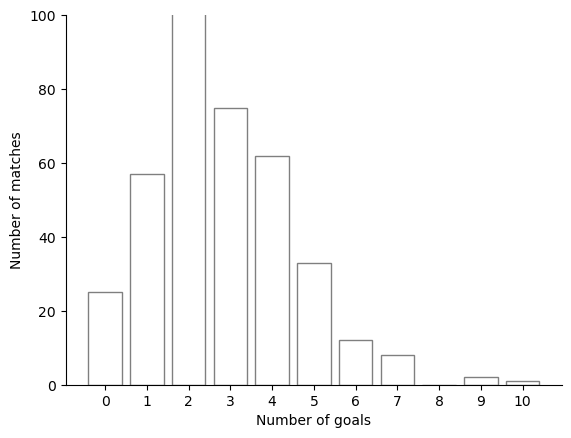

In [4]:
#  We now simulate 380 matches of a football season and look at how well it predicts the
#  distribution of the number of goals. This is done in the code below: we loop over 380 matches,
#  store the number of goals for each match in array and then we make a histogram of the number of goals.

def simulateMatch(n, p):
    # n - number of time units
    # p - probability per time unit of a goal
    # display_match == True then display simulation output for match.
    
    # Counting the number of goals
    goals = 0
    
    for minute in range(n):
        # Generating a random number between 0 and 1.
        r = rnd.rand(1, 1)
        # Printing an X when there is a goal and a zero otherwise.
        if (r < p):
            # Goal - if the random number is less than the goal probability.
            goals = goals + 1

    return goals

# Defining the number of matches
num_matches = 380

# Looping over all the matches and print the number of goals.
goals = np.zeros(num_matches)
for i in range(num_matches):
    goals[i] = simulateMatch(match_minutes, prob_per_minute)
    #print('In match ' + str(i+1) + ' there were ' + str(int(goals[i])) + ' goals.')

# Creating a histogram
fig, ax = plt.subplots(num=1)

histogram_range = np.arange(-0.5, 10.51, 1)
histogram_goals = np.histogram(goals, histogram_range)

ax.bar(histogram_goals[1][:-1] + 0.5, histogram_goals[0], color='white', edgecolor='black', linestyle='-', alpha=0.5)
ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 11, step=1))
ax.set_yticks(np.arange(0, 101, step=20))
ax.set_xlabel('Number of goals')
ax.set_ylabel('Number of matches')
plt.show()

## Simulating results

### Import data

In [5]:
epl = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
ep = epl[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl.head()

epl = epl[:-10]
epl.mean()

HomeGoals     1.491892
AwayGoals     1.297297
HTHG          0.686486
HTAG          0.586486
HS           13.764865
               ...    
PCAHA         1.976486
MaxCAHH       2.019946
MaxCAHA       2.054649
AvgCAHH       1.925973
AvgCAHA       1.959514
Length: 98, dtype: float64

### Perform the regression

In [6]:
# Renaming data
goal_model_data = pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1043.1
Date:                Wed, 06 Sep 2023   Deviance:                       776.72
Time:                        16:32:24   Pearson chi2:                     681.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2498
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2470      0.203      1.214      0.225      -0.152       0.646
team[T.Aston Villa]           -0.1298      0.195     -0.666      0.506      -0.512       0.252
team[T.Brentford]             -0.1589      0.198     -0.802      0.423      -0.547       0.230
team[T.Brighton]              -0.3735      0.209     -1.788      0.074      -0.783       0.036
team[T.Burnley]               -0.5263      0.220     -2.395      0.017      -0.957      -0.096
team[T.Chelsea]                0.2714      0.177      1.529      0.126      -0.077       0.619
team[T.Crystal Palace]        -0.1370      0.196     -0.699      0.484      -0.521       0.247
team[T.Everton]               -0.2847      0.204     -1.394      0.163      -0.685       0.116
team[T.Leeds]                 -0.3127      0.207     -1.507      0.132      -0.719       0.094
team[T.Leicester]              0.0481      0.188      0.256      0.798      -0.320       0.416
team[T.Liverpool]              0.4522      0.170      2.657      0.008       0.119       0.786
team[T.Man City]               0.5115      0.168      3.036      0.002       0.181       0.842
team[T.Man United]             0.0156      0.189      0.083      0.934      -0.354       0.385
team[T.Newcastle]             -0.2841      0.204     -1.389      0.165      -0.685       0.117
team[T.Norwich]               -0.8697      0.248     -3.507      0.000      -1.356      -0.384
team[T.Southampton]           -0.2770      0.205     -1.354      0.176      -0.678       0.124
team[T.Tottenham]              0.1294      0.183      0.706      0.480      -0.230       0.489
team[T.Watford]               -0.5181      0.220     -2.357      0.018      -0.949      -0.087
team[T.West Ham]               0.0398      0.187      0.213      0.831      -0.327       0.406
team[T.Wolves]                -0.4429      0.212     -2.088      0.037      -0.859      -0.027
opponent[T.Aston Villa]        0.1071      0.203      0.529      0.597      -0.290       0.504
opponent[T.Brentford]          0.1297      0.200      0.649      0.516      -0.262       0.521
opponent[T.Brighton]          -0.0994      0.211     -0.470      0.638      -0.514       0.315
opponent[T.Burnley]            0.0579      0.202      0.286      0.775      -0.339       0.455
opponent[T.Chelsea]           -0.3702      0.230     -1.613      0.107      -0.820       0.080
opponent[T.Crystal Palace]    -0.0219      0.208     -0.105      0.916      -0.429       0.385
opponent[T.Everton]            0.2573      0.194      1.325      0.185      -0.123       0.638
opponent[T.Leeds]              0.4973      0.185      2.688      0.007       0.135       0.860
opponent[T.Leicester]          0.2134      0.197      1.085      0.278      -0.172       0.599
opponent[T.Liverpool]         -0.6001      

### Simulating a game

In [7]:
# Setting teams for the match
home_team='Man City'
away_team='Arsenal'

# Predicting for Manchester City vs. Arsenal
home_score_rate = poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[1]))
away_score_rate = poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':0},index=[1]))
print(home_team + ' against ' + away_team + ' expect to score: ' + str(home_score_rate))
print(away_team + ' against ' + home_team + ' expect to score: ' + str(away_score_rate))

# Getting a prediction
home_goals = np.random.poisson(home_score_rate)
away_goals = np.random.poisson(away_score_rate)
print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))

Man City against Arsenal expect to score: 1    2.481142
dtype: float64
Arsenal against Man City expect to score: 1    0.682894
dtype: float64
Man City: 1
Arsenal: 0


### Two-dimensional histogram of scores

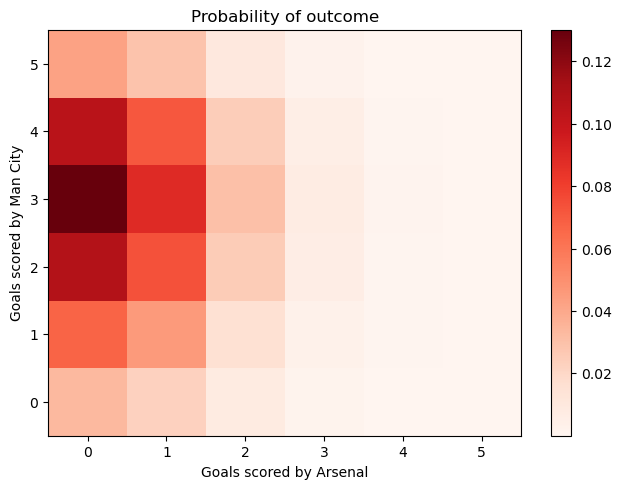

In [8]:
# Defining function to calculate the goals for the match
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam,
                                                           'opponent': awayTeam, 'home': 1},
                                                     index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam,
                                                           'opponent': homeTeam, 'home': 0},
                                                     index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in
                 [home_goals_avg, away_goals_avg]]
    
    return (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

# Filling the matrix
max_goals = 5
score_matrix = simulate_match(poisson_model, home_team, away_team, max_goals)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
pos = ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

## Statistical modeling

### Preparing data

In [9]:
# Opening data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)

# Getting team names
teams = df_match["home_team_name"].unique()

# Getting game indices
match_ids = df_match["match_id"]

# Initializing data frames
passshot_df = pd.DataFrame()
danger_passes_df = pd.DataFrame()

for idx in match_ids:
    # Opening event data
    df = parser.event(idx)[0]
    
    # Getting home and away teams
    home_team = df_match.loc[df_match["match_id"] == idx]["home_team_name"].iloc[0]
    away_team = df_match.loc[df_match["match_id"] == idx]["away_team_name"].iloc[0]
    
    for team in [home_team, away_team]:
        # Initializing variables to sum shots, passes and danger passes
        shots = 0
        passes = 0
        danger_passes = 0
        
        for period in [1, 2]:
            # Passes
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            pass_df = df.loc[mask_pass]
            
            # Shots
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            shot_df = df.loc[mask_shot, ["minute", "second"]]
            
            # Finding passes within 15 seconds of a shot, excluding corners
            shot_times = shot_df['minute'] * 60 + shot_df['second'] # Converting time to seconds
            shot_window = 15
            shot_start = shot_times - shot_window # Finding starts of the window
            shot_start = shot_start.apply(lambda i: i if i>0 else (period - 1) * 45) # condition to avoid negative shot starts
            pass_times = pass_df['minute'] * 60 + pass_df['second'] # Converting time to seconds
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique()) # checking if pass is in any of the windows for this half
            danger_passes_period = pass_df.loc[pass_to_shot]

            # Danger passes
            danger_passes_df = pd.concat([danger_passes_df, danger_passes_period], ignore_index = True)

            # Adding number of passes, shots and danger passes from a game
            passes += len(pass_df)
            shots += len(shot_df)
            danger_passes += len(danger_passes_period)
            
        # Getting number of goals by the team from the game
        if team == home_team:
            goals = df_match.loc[df_match["match_id"] == idx]["home_score"].iloc[0]
        else:
            goals = df_match.loc[df_match["match_id"] == idx]["away_score"].iloc[0]
        
        # Adding it at the end of the passshot dataframe
        match_info_df = pd.DataFrame({
                    "Team": [team],
                    "Passes": [passes],
                    "Shots": [shots],
                    "Goals": [goals],
                    "Danger Passes": [danger_passes]
                    })
        passshot_df = pd.concat([passshot_df, match_info_df])

### Plotting data

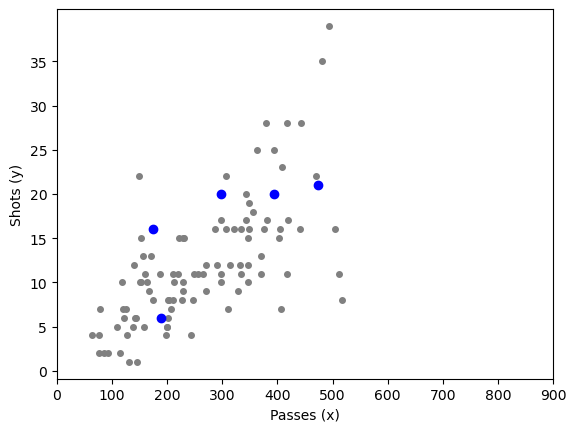

In [10]:
fig, ax = plt.subplots()

# Plotting games
ax.plot('Passes','Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')

# Choosing choose only France games
france_df  = passshot_df.loc[passshot_df["Team"] == "France Women's"]
ax.plot('Passes','Shots', data=france_df, linestyle='none', markersize=6, marker='o', color='blue')

# Making legend
ax.set_xticks(np.arange(0,1000,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')
plt.show()

### Fitting linear regression

                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     88.98
Date:                Wed, 06 Sep 2023   Prob (F-statistic):           1.46e-15
Time:                        16:33:27   Log-Likelihood:                -318.20
No. Observations:                 104   AIC:                             640.4
Df Residuals:                     102   BIC:                             645.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3098      1.268      1.033      0.3

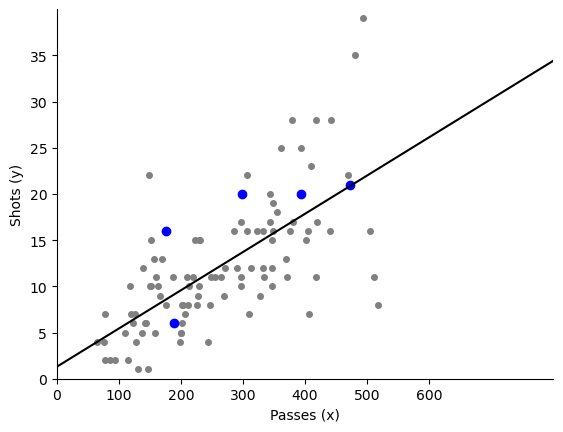

In [11]:
fig,ax=plt.subplots()

# Plotting games
ax.plot('Passes','Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')

# Choosing choose only France games
france_df  = passshot_df.loc[passshot_df["Team"] == "France Women's"]
ax.plot('Passes','Shots', data=france_df, linestyle='none', markersize=6, marker='o', color='blue')

# Making legend
ax.set_xticks(np.arange(0,700,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')

# Changing datatype for smf
passshot_df['Shots']= pd.to_numeric(passshot_df['Shots'])
passshot_df['Passes']= pd.to_numeric(passshot_df['Passes'])
passshot_df['Goals']= pd.to_numeric(passshot_df['Goals'])

# Fitting the model
model_fit=smf.ols(formula='Shots ~ Passes', data=passshot_df[['Shots','Passes']]).fit()

# Printing summary
print(model_fit.summary())

# Getting coefficients
b = model_fit.params

# Plotting line
x = np.arange(0, 1000, step=0.5)
y = b[0] + b[1]*x
ax.plot(x, y, linestyle='-', color='black')

# Making legend
ax.set_ylim(0,40)
ax.set_xlim(0,800)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Fitting Poisson regression

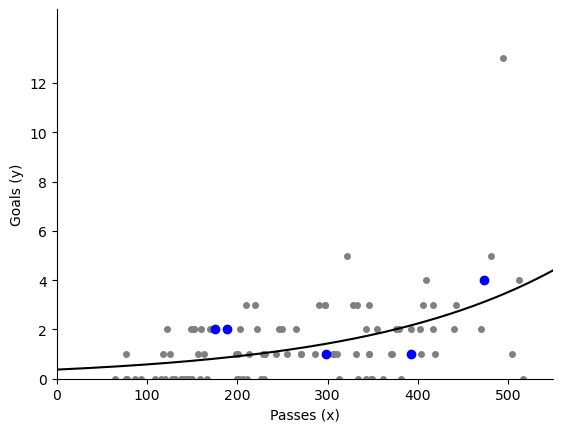

In [12]:
fig,ax=plt.subplots()

# Plotting all games
ax.plot('Passes','Goals', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')

# Choosing choose only France games
france_df  = passshot_df.loc[passshot_df["Team"] == "France Women's"]
ax.plot('Passes','Goals', data=france_df, linestyle='none', markersize=6, marker='o', color='blue')

# Making legend
ax.set_xticks(np.arange(0,700,step=100))
ax.set_yticks(np.arange(0,13,step=2))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Goals (y)')

# Fitting the model
poisson_model = smf.glm(formula="Goals ~ Passes", data=passshot_df,
                    family=sm.families.Poisson()).fit()

# Printing summary
poisson_model.summary()

# Getting coefficients
b = poisson_model.params

# Plotting line
x = np.arange(0, 1000, step=0.5)
y = np.exp(b[0] + b[1]*x)
ax.plot(x, y, linestyle='-', color='black')

# Making legend
ax.set_ylim(0,15)
ax.set_xlim(0,550)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Comparative heatmaps

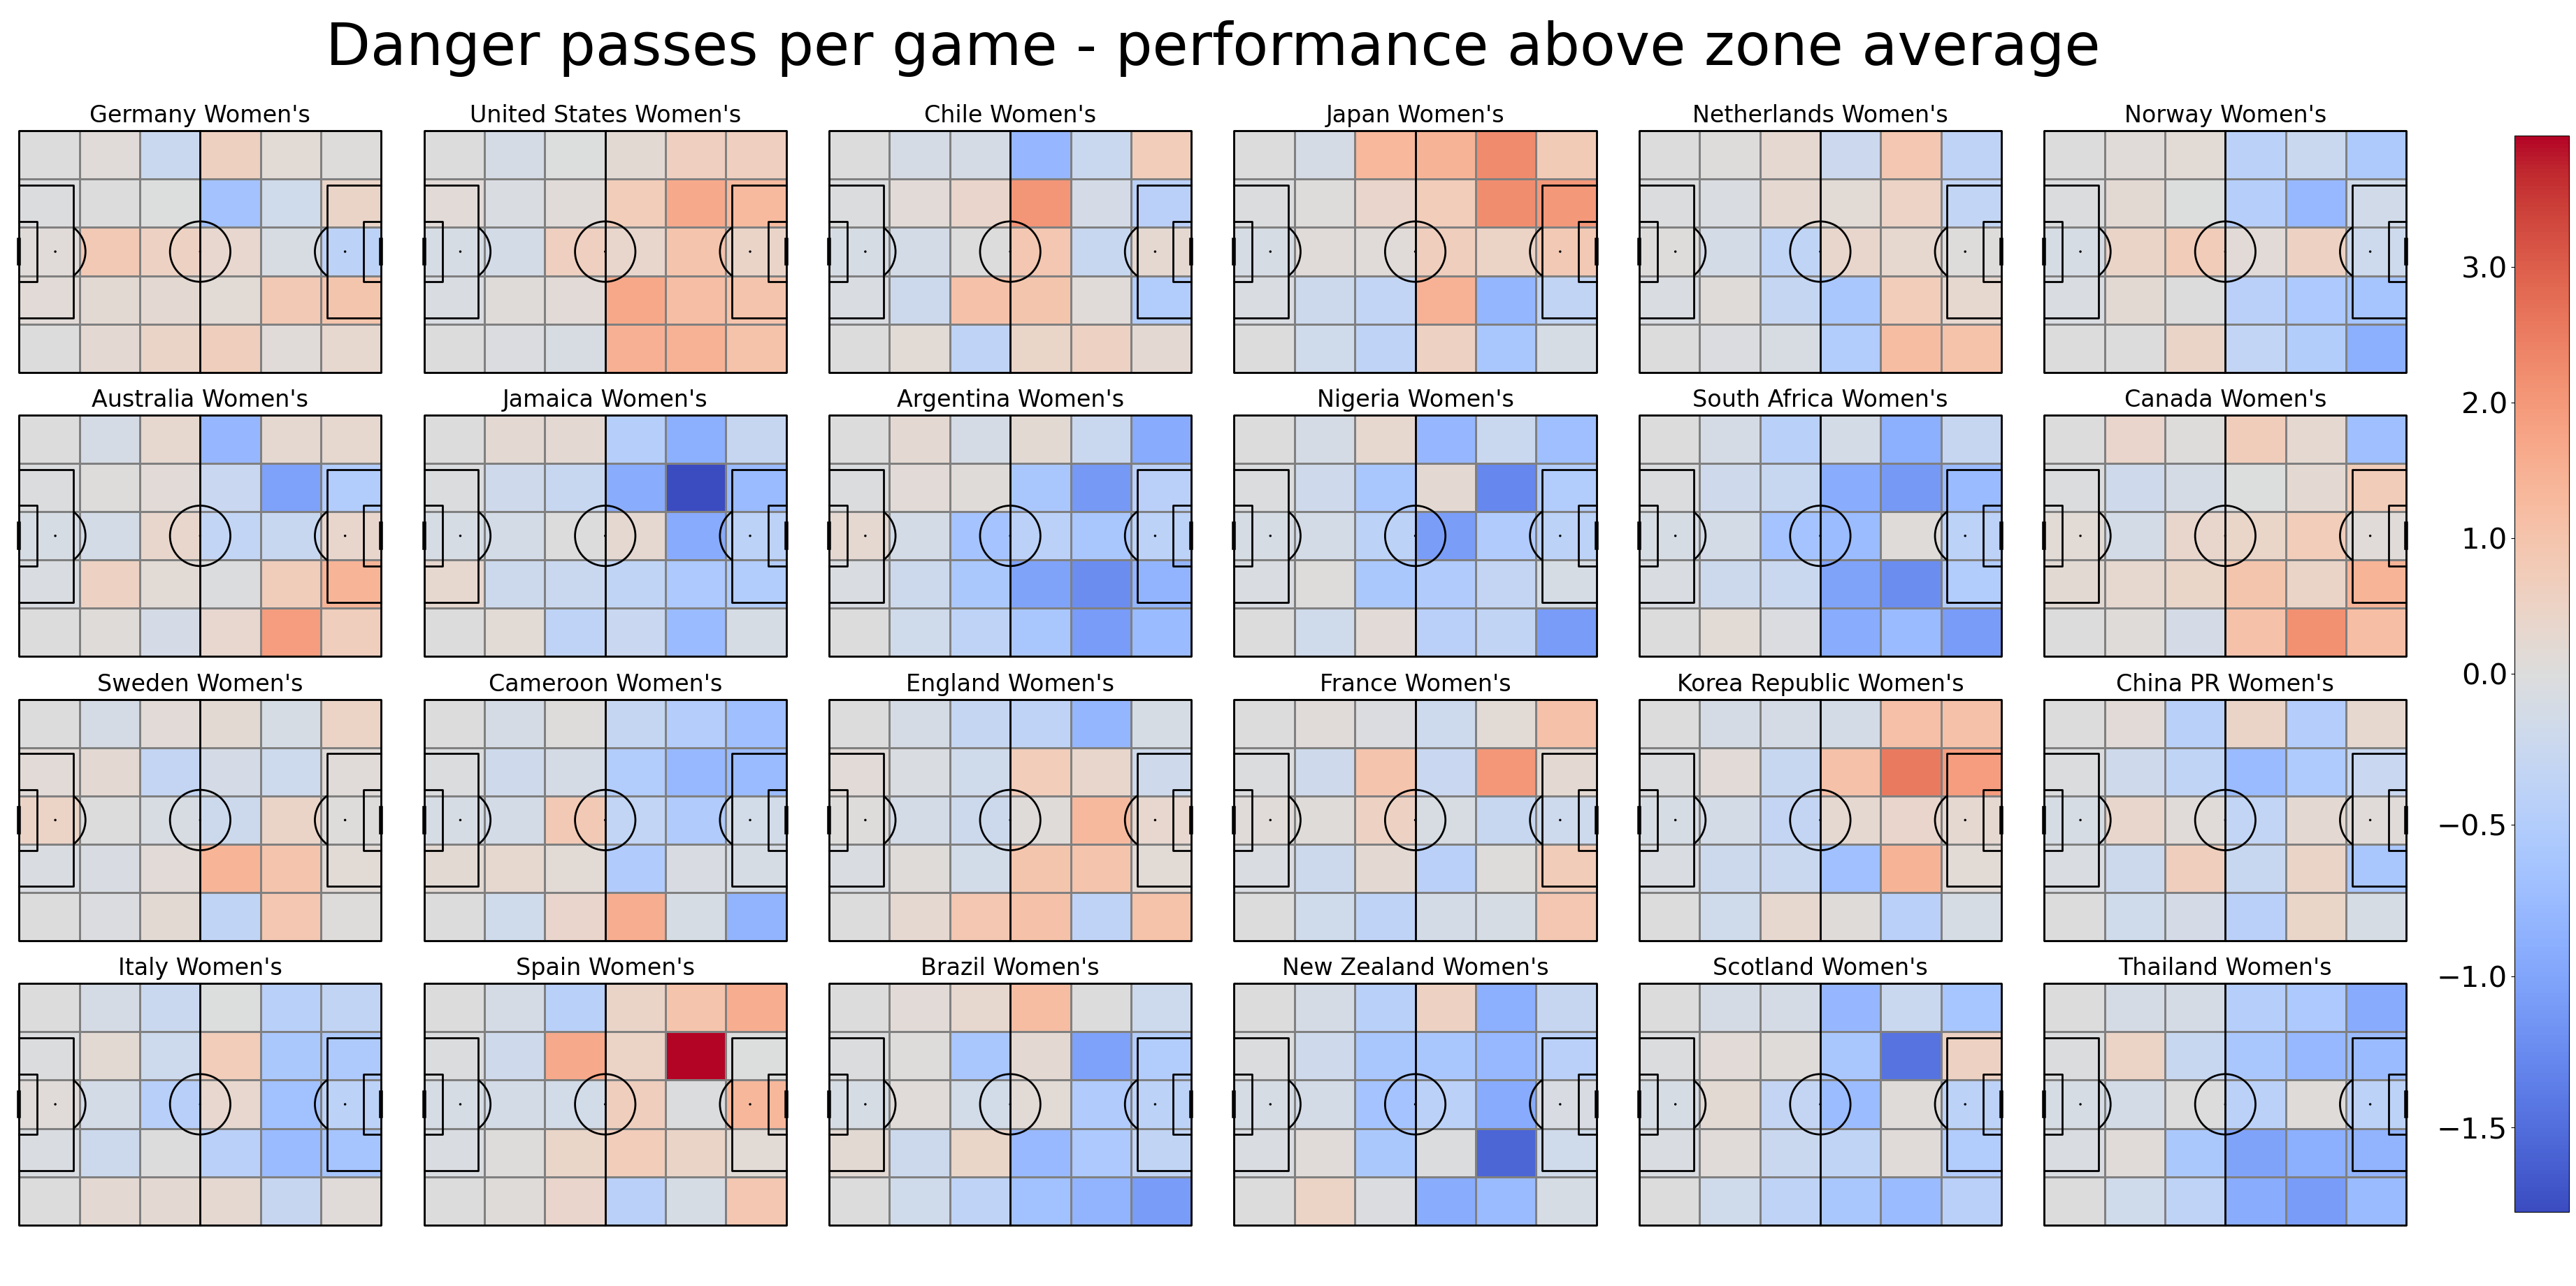

In [13]:
# Plotting pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 6, nrows = 4, figheight=20,
                      grid_width=0.88, left=0.025,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=0.8)

# Storing bins in a dictionary for each team
hist_dict = {}
for team in teams:
    #get number of games by team
    no_games = len(df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)])
    #get danger passes only by this team
    team_danger_passes = danger_passes_df.loc[danger_passes_df["team_name"] == team]
    #number of danger passes in each zone
    bin_statistic = pitch.bin_statistic(team_danger_passes.x, team_danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
    #normalize by number of games
    bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
    #store in dictionary
    hist_dict[team] = bin_statistic

# Calculating average per game per team per zone
avg_hist = np.mean(np.array([v["statistic"] for k,v in hist_dict.items()]), axis=0)

# Subtracting average
for team in teams:
    hist_dict[team]["statistic"] = hist_dict[team]["statistic"] - avg_hist

# Preparing colormap
vmax = max([np.amax(v["statistic"]) for k,v in hist_dict.items()])
vmin = min([np.amin(v["statistic"]) for k,v in hist_dict.items()])
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

#for each player
for team, ax in zip(teams, axs['pitch'].flat):
    # Putting team name over the plot
    ax.text(60, -5, team,
            ha='center', va='center', fontsize=24)
    # Plotting colormap
    pcm  = pitch.heatmap(hist_dict[team], ax=ax, cmap='coolwarm', norm = divnorm, edgecolor='grey')

# Making legend
ax_cbar = fig.add_axes((0.94, 0.093, 0.02, 0.77))
cbar = plt.colorbar(pcm, cax=ax_cbar, ticks=[-1.5, -1, -0.5, 0, 1, 2, 3])
cbar.ax.tick_params(labelsize=30)
ax_cbar.yaxis.set_ticks_position('left')

# Adding title
axs['title'].text(0.5, 0.5, 'Danger passes per game - performance above zone average', ha='center', va='center', fontsize=60)
plt.show()

## Points moving average

### Downloading data

In [14]:
# Initializing the list of dataframes
dflist = []

# Initializing the list of all seasons
seasonst = []

# Taking 6 years of games
for year in range(16,22,1):
    
    # Creating a string with season name
    if year < 9:
        yeartext = '0'+str(year)+'0'+str(year+1)
        yeartext2 = '0'+str(year)+'-0'+str(year+1)
    elif year == 9:
        yeartext = '0910'
        yeartext2 = '09-10'
    else:
        yeartext = str(year)+str(year+1)
        yeartext2 = str(year)+'-'+str(year+1)
        
    # Getting data from webpage
    performance_year = pd.read_csv("https://www.football-data.co.uk/mmz4281/"+yeartext+"/E0.csv",delimiter=',')
    
    # Adding the season name to the list of all seasons
    seasonst.append(yeartext2)
    
    # Making a list of dataframes
    dflist.append(performance_year)
    
# Putting dataframes into a big dataframe
performance = pd.concat(dflist).reset_index()

### Preparing data

In [15]:
# Getting Top 6 teams
teams = ['Man City', 'Liverpool', 'Arsenal', 'Chelsea', 'Tottenham', 'Man United']

# Initializing a dictionary to store data
team_dfs = dict()

for team in teams:
    # Initializing an empty dataframe
    team_df = pd.DataFrame(columns = ["Points", "Date", "Game"])
    
    # Getting matches by this team
    matches = performance.loc[(performance['AwayTeam'] == team) | (performance['HomeTeam'] == team)]
    
    # Defining an auxilliary variable that will be helpful to plot
    game = 0
    for i, match in matches.iterrows():
        game +=1

        if match['AwayTeam'] == team:
            # Getting goals for both teams
            goalsfor = match['FTAG']
            goalsagainst = match['FTHG']
            
            # Assigning 3 points if win, 1 if draw, 0 if lost
            if match['FTR'] == 'A':
                points = 3
            elif match['FTR'] == 'D':
                points = 1
            else:
                points = 0
        else:
            # Getting goals for both teams
            goalsfor = match['FTHG']
            goalsagainst = match['FTAG']
            # Assigning 3 points if win, 1 if draw, 0 if lost
            if match['FTR'] == 'H':
                points = 3
            elif match['FTR'] == 'D':
                points = 1
            else:
                points = 0
        
        # Assigning values to dataframe
        team_df.at[i, "Points"] = points
        team_df.at[i, "Game"] = game
    
    # Calculating rolling average
    team_df['PointsRA'] = team_df['Points'].rolling(window=10, win_type='triang').mean()
    
    # Adding the team dataframe to the big one
    team_dfs[team] = team_df

### Making plot

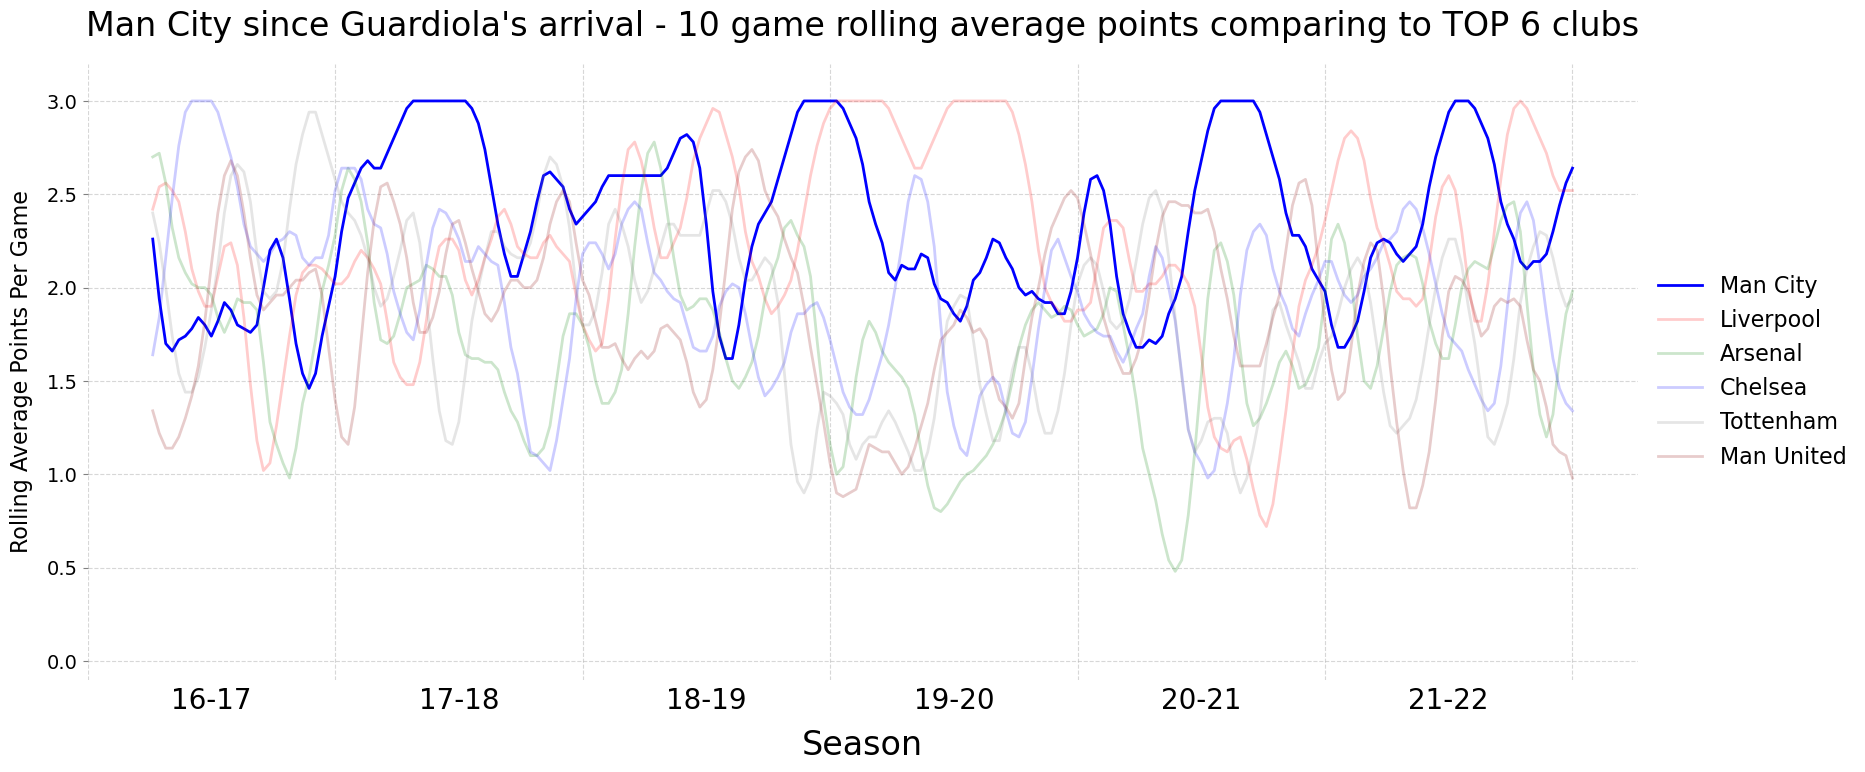

In [16]:
# Creating plot
fig, ax = plt.subplots(figsize=(20, 8))

# Arsenal got yellow because of those 2004 kits, but it was invisible so they got green
colors = ['blue', 'red', 'green', 'blue', 'grey', 'darkred']

# Highlighting more Manchester City
alphas = [1, 0.2, 0.2, 0.2, 0.2, 0.2]
for club, color, alpha in zip(teams, colors, alphas):
    ax.plot(team_dfs[club]['Game'],  team_dfs[club]['PointsRA'], linewidth=2, linestyle='-',color=color, alpha = alpha, zorder = 2, label = club)

# Setting title
ax.set_title("Man City since Guardiola's arrival - 10 game rolling average points comparing to TOP 6 clubs", fontsize = 24, pad=20)

# Making visible ticks for beginning of each season
ax.set_xticks(np.arange(0, max(team_dfs["Liverpool"]['Game']) + 38, 38))
ax.set_xticklabels([])

# Making ticks in the middle
ax.set_xticks(np.arange(0, max(team_dfs["Liverpool"]['Game']), 38) + 19, minor=True)

# Putting season text in the middle of season
ax.set_xticklabels(seasonst, minor=True)

# Setting axis limits
ax.set_xlim(0, max(team_dfs["Liverpool"]['Game']) + 10)
ax.set_ylim(-0.1,3.2)

# Disabling black ticks, but big text xaxis
ax.tick_params(axis='x', color='white', which='both', labelsize = 20)

# Coloring y ticks
ax.tick_params(axis='y', color='grey', labelsize = 14)

# Adding grid
ax.grid(zorder = 1, linestyle = "--", alpha = 0.5)

# Disabling spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Adding axis labels
ax.set_ylabel('Rolling Average Points Per Game', fontsize = 16,labelpad=10)
ax.set_xlabel('Season', fontsize = 24, labelpad=10)

# Making legend
plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left",fontsize=16, edgecolor='white')
plt.show()